# 5 Base de dados The Simpsons

Baixe a base de dados com os episódios do The Simpsons no Kaggle. Utilize os códigos de referência do curso para combinar todos os arquivos CSVs num único dataset. Utilize a biblioteca tiktoken com a codificação cl100k_base para descrever a quantidade de tokens por episódios e temporada. 

Quantos tokens em média tem um episódio? E temporada? Qual foi a temporada e o episódio com mais tokens? Faça uma análise descritiva.
Utilize a técnica de Prompt Chaining para fazer uma análise descritiva das avaliações do IMDB e da audiência dos episódios. Justifique os prompts gerados.

Fonte Kaggle: https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset

In [1]:
# imports 
import os
import pandas as pd
import tiktoken
import numpy as np

import google.generativeai as genai
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import kagglehub


c:\infnet_ultimo_semestre\TP3_Eng_de_Prompt_Parte_2_local\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path do dataset baixado
path = kagglehub.dataset_download("prashant111/the-simpsons-dataset")
print("Path to dataset files:", path)

# Carregar os datasets
df_script = pd.read_csv(os.path.join(path, 'simpsons_script_lines.csv'), low_memory=False)
df_episodes = pd.read_csv(os.path.join(path, 'simpsons_episodes.csv'), low_memory=False)
df_characters = pd.read_csv(os.path.join(path, 'simpsons_characters.csv'), low_memory=False)
df_locations = pd.read_csv(os.path.join(path, 'simpsons_locations.csv'), low_memory=False)

# Preparar os datasets
df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

# Adicionar prefixos
df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

# Realizar merge
data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)

# Verificar integridade
assert data.shape[0] == df_script.shape[0]

# Imprimir informações sobre o dataset combinado
print("\nInformações do dataset combinado:")
print("Número total de linhas:", data.shape[0])
print("Número total de colunas:", data.shape[1])
print("\nColunas do dataset:")
print(data.columns.tolist())

# Salvar o DataFrame combinado na raiz do projeto
try:
    data.to_csv('simpsons_combined_data.csv', index=True)
    print("\nDataFrame salvo com sucesso como 'simpsons_combined_data.csv'")
except Exception as e:
    print(f"\nErro ao salvar o DataFrame: {str(e)}")

Path to dataset files: C:\Users\giova\.cache\kagglehub\datasets\prashant111\the-simpsons-dataset\versions\1

Informações do dataset combinado:
Número total de linhas: 158271
Número total de colunas: 30

Colunas do dataset:
['episode_id', 'number', 'raw_text', 'timestamp_in_ms', 'speaking_line', 'character_id', 'location_id', 'raw_character_text', 'raw_location_text', 'spoken_words', 'normalized_text', 'word_count', 'episode_image_url', 'episode_imdb_rating', 'episode_imdb_votes', 'episode_number_in_season', 'episode_number_in_series', 'episode_original_air_date', 'episode_original_air_year', 'episode_production_code', 'episode_season', 'episode_title', 'episode_us_viewers_in_millions', 'episode_video_url', 'episode_views', 'character_name', 'character_normalized_name', 'character_gender', 'location_name', 'location_normalized_name']

DataFrame salvo com sucesso como 'simpsons_combined_data.csv'


In [3]:
# Função para contar tokens
def count_tokens(text):
    encoder = tiktoken.get_encoding("cl100k_base")
    return len(encoder.encode(str(text)))

# Contar tokens por episódio
def count_episode_tokens(episode_data):
    # Concatenar todos os textos normalizados do episódio
    episode_text = ' '.join(episode_data['normalized_text'].dropna())
    return count_tokens(episode_text)

# Agrupar por episódio e contar tokens
episode_tokens = data.groupby(['episode_season', 'episode_title']).apply(count_episode_tokens).reset_index()
episode_tokens.columns = ['season', 'title', 'tokens']

# Análise descritiva de tokens
tokens_summary = episode_tokens.groupby('season')['tokens'].agg([
    ('mean_tokens', 'mean'),
    ('max_tokens', 'max'),
    ('min_tokens', 'min'),
    ('total_episodes', 'count')
])

print("Análise de Tokens por Temporada:")
print(tokens_summary)

# Episódio com mais tokens
max_tokens_episode = episode_tokens.loc[episode_tokens['tokens'].idxmax()]
print("\nEpisódio com mais tokens:")
print(f"Título: {max_tokens_episode['title']}")
print(f"Temporada: {max_tokens_episode['season']}")
print(f"Tokens: {max_tokens_episode['tokens']}")

# Estatísticas gerais de tokens
print("\nEstatísticas Gerais de Tokens:")
print(episode_tokens['tokens'].describe())

Análise de Tokens por Temporada:
        mean_tokens  max_tokens  min_tokens  total_episodes
season                                                     
1       2814.846154        3216        2476              13
2       2952.863636        3323        2368              22
3       2866.208333        3422        2433              24
4       2395.136364        2671        1622              22
5       2649.954545        3076        1934              22
6       2630.320000        3168        2160              25
7       2798.760000        3156        2272              25
8       2751.640000        3184        2326              25
9       2569.560000        3064         861              25
10      2730.347826        3079        2156              23
11      2692.954545        3040        2388              22
12      2451.476190        2809        1959              21
13      2327.000000        2756        1243              22
14      2583.409091        3061        2183              22
15     

C:\Users\giova\AppData\Local\Temp\ipykernel_5856\2800432613.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  episode_tokens = data.groupby(['episode_season', 'episode_title']).apply(count_episode_tokens).reset_index()


### Pergunta 1: Quantos tokens em média tem um episódio? E temporada? Qual foi a temporada e o episódio com mais tokens? Faça uma análise descritiva.

In [4]:
from IPython.display import Markdown, display

def interpret_token_stats(stats):
    markdown_text = f"""
## Análise Descritiva dos Tokens nos Episódios de The Simpsons

### Visão Geral Estatística
- **Número Total de Episódios Analisados**: {stats['count']}
- **Média de Tokens por Episódio**: {stats['mean']:.2f} tokens
- **Desvio Padrão**: {stats['std']:.2f} tokens

### Distribuição de Tokens
- **Mínimo**: {stats['min']:.0f} tokens
- **Máximo**: {stats['max']:.0f} tokens
- **Mediana (50%)**: {stats['50%']:.2f} tokens

### Interpretação Detalhada
1. **Consistência Narrativa**
   - A pequena variação no desvio padrão (cerca de {(stats['std']/stats['mean']*100):.1f}% da média) sugere uma consistência significativa no tamanho dos diálogos entre os episódios.

2. **Amplitude de Variação**
   - Existe uma variação considerável entre o episódio mais curto ({stats['min']:.0f} tokens) e o mais longo ({stats['max']:.0f} tokens), representando uma diferença de quase {stats['max']/stats['min']:.1f} vezes.

3. **Distribuição Simétrica**
   - A proximidade entre média ({stats['mean']:.2f}) e mediana ({stats['50%']:.2f}) indica uma distribuição relativamente simétrica dos tokens.

4. **Quartis**
   - 25% dos episódios têm até {stats['25%']:.0f} tokens
   - 75% dos episódios têm até {stats['75%']:.0f} tokens

### Conclusão
Os episódios de The Simpsons mantêm uma notável consistência no volume de diálogos, com variações que provavelmente refletem diferenças na complexidade narrativa de cada episódio.
"""
    display(Markdown(markdown_text))

# Chamar a função com as estatísticas
interpret_token_stats(episode_tokens['tokens'].describe())


## Análise Descritiva dos Tokens nos Episódios de The Simpsons

### Visão Geral Estatística
- **Número Total de Episódios Analisados**: 564.0
- **Média de Tokens por Episódio**: 2584.05 tokens
- **Desvio Padrão**: 295.80 tokens

### Distribuição de Tokens
- **Mínimo**: 861 tokens
- **Máximo**: 3422 tokens
- **Mediana (50%)**: 2597.00 tokens

### Interpretação Detalhada
1. **Consistência Narrativa**
   - A pequena variação no desvio padrão (cerca de 11.4% da média) sugere uma consistência significativa no tamanho dos diálogos entre os episódios.

2. **Amplitude de Variação**
   - Existe uma variação considerável entre o episódio mais curto (861 tokens) e o mais longo (3422 tokens), representando uma diferença de quase 4.0 vezes.

3. **Distribuição Simétrica**
   - A proximidade entre média (2584.05) e mediana (2597.00) indica uma distribuição relativamente simétrica dos tokens.

4. **Quartis**
   - 25% dos episódios têm até 2406 tokens
   - 75% dos episódios têm até 2778 tokens

### Conclusão
Os episódios de The Simpsons mantêm uma notável consistência no volume de diálogos, com variações que provavelmente refletem diferenças na complexidade narrativa de cada episódio.


In [5]:
# Carregar variáveis de ambiente
load_dotenv()

# Configurar API do Google
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel('gemini-1.5-pro')

# Preparar dados para análise
df_ratings = data[['episode_season', 'episode_title', 'episode_imdb_rating', 'episode_us_viewers_in_millions']].drop_duplicates()


In [6]:
# Função de Prompt Chaining
def prompt_chain_imdb_analysis(df):
    # Justificativa dos Prompts:
    # 1. Primeiro prompt: Análise estatística descritiva para estabelecer contexto
    # 2. Segundo prompt: Análise de tendências por temporada para identificar padrões evolutivos
    # 3. Terceiro prompt: Correlação entre audiência e avaliações para insights mais profundos

    # Prompt 1: Análise Estatística Descritiva
    prompt1 = f"""
    Análise estatística das avaliações de IMDB de The Simpsons:
    
    Dados de entrada:
    - Total de episódios: {len(df)}
    - Média de avaliação IMDB: {df['episode_imdb_rating'].mean():.2f}
    - Mediana de avaliação: {df['episode_imdb_rating'].median():.2f}
    - Desvio padrão: {df['episode_imdb_rating'].std():.2f}
    - Mínima avaliação: {df['episode_imdb_rating'].min():.2f}
    - Máxima avaliação: {df['episode_imdb_rating'].max():.2f}

    Forneça uma análise detalhada sobre a distribuição das avaliações, destacando:
    1. Significado estatístico das variações
    2. Possíveis fatores que influenciam as notas
    3. Interpretação da qualidade geral da série
    """

    response1 = model.generate_content(prompt1)
    
    # Prompt 2: Análise de Tendências por Temporada
    season_ratings = df.groupby('episode_season')['episode_imdb_rating'].agg(['mean', 'min', 'max'])
    prompt2 = f"""
    Análise de tendências de avaliações por temporada de The Simpsons:
    
    Dados de avaliação por temporada:
    {season_ratings}

    Analise:
    1. Evolução da qualidade ao longo das temporadas
    2. Temporadas com melhores e piores avaliações
    3. Possíveis razões para variações nas notas entre temporadas
    4. Pontos de inflexão na qualidade da série
    """

    response2 = model.generate_content(prompt2)
    
    # Prompt 3: Análise Comparativa de Audiência e Avaliações
    correlation = df['episode_imdb_rating'].corr(df['episode_us_viewers_in_millions'])
    prompt3 = f"""
    Análise da relação entre audiência e avaliações de IMDB:
    
    Dados:
    - Correlação entre avaliações IMDB e audiência: {correlation:.2f}
    - Média de visualizações: {df['episode_us_viewers_in_millions'].mean():.2f} milhões
    - Média de avaliação IMDB: {df['episode_imdb_rating'].mean():.2f}

    Investigue:
    1. Relação entre qualidade (IMDB) e audiência
    2. Impacto da popularidade nas avaliações
    3. Variações de audiência ao longo das temporadas
    4. Fatores que podem explicar a correlação observada
    """

    response3 = model.generate_content(prompt3)
    
    return {
        'estatistica_descritiva': response1.text,
        'tendencias_temporadas': response2.text,
        'analise_audiencia': response3.text
    }


### Pergunta 2: Utilize a técnica de Prompt Chaining para fazer uma análise descritiva das avaliações do IMDB e da audiência dos episódios. Justifique os prompts gerados.

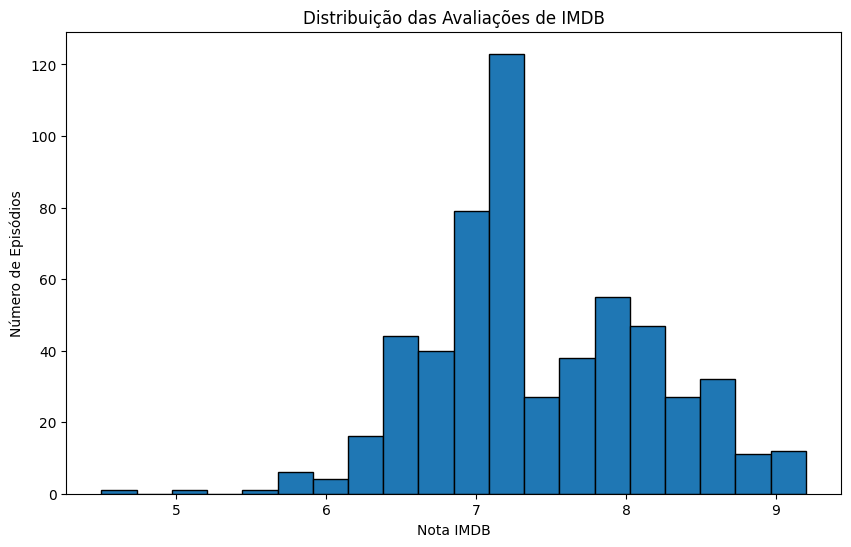


--- Estatistica Descritiva ---
## Análise Estatística das Avaliações IMDB de The Simpsons

Os dados fornecidos permitem uma análise interessante da recepção dos episódios de The Simpsons pelo público do IMDB.

**1. Significado Estatístico das Variações:**

* **Média (7.42):** Uma média de 7.42 em 10 indica uma recepção geralmente positiva da série.  Em termos gerais, isso sugere que a maioria dos episódios é considerada boa ou muito boa.
* **Mediana (7.30):**  A mediana ser ligeiramente inferior à média (7.30) sugere uma leve assimetria à esquerda na distribuição. Isso implica que há mais episódios com notas abaixo da média do que acima, possivelmente devido à presença de alguns episódios com notas consideravelmente baixas que puxam a média para baixo, sem afetar tanto a mediana.
* **Desvio Padrão (0.73):** Um desvio padrão de 0.73 indica uma variabilidade moderada nas avaliações. Isso significa que a maioria das notas se concentra em torno da média (7.42), com uma dispersão relativam

In [7]:
# Executar análise
resultados = prompt_chain_imdb_analysis(df_ratings)

# Visualização de Distribuição de Avaliações
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['episode_imdb_rating'], bins=20, edgecolor='black')
plt.title('Distribuição das Avaliações de IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Número de Episódios')
plt.show()

# Salvar resultados
with open('simpsons_analysis_results.txt', 'w', encoding='utf-8') as f:
    for chave, valor in resultados.items():
        f.write(f"\n--- {chave.replace('_', ' ').title()} ---\n")
        f.write(valor)
        f.write("\n\n")

# Imprimir resultados
for chave, valor in resultados.items():
    print(f"\n--- {chave.replace('_', ' ').title()} ---")
    print(valor)

# 6 Classificação de Sentimento com Few-Shot Learning

Implemente um modelo de classificação de sentimentos em Python para categorizar trechos de diálogo dos Simpsons como “Positivo”, “Neutro” ou “Negativo”. Use a técnica de few-shot learning, incluindo 5 exemplos por categoria no prompt. Selecione o episódio número 92 (episode_id) da temporada 5 (episode_season). Utilize a técnica de batch-prompting para classificar múltiplas falas num único prompt. Responda às perguntas:

* Quantas chamadas ao LLM foram necessárias?
* Qual é a distribuição de fala por categoria?
* Avaliando 5 falas de cada classe, qual é a acurácia do modelo?
* Qual foi a precisão do modelo para cada classe?

In [8]:
import os
import pandas as pd
import google.generativeai as genai
from dotenv import load_dotenv

# Carregar variáveis de ambiente
load_dotenv()

# Configurar API do Google
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

# Modelo Gemini
model = genai.GenerativeModel('gemini-pro')

def sentiment_classification_with_few_shot(dialogs):
    # Exemplos few-shot para cada categoria
    few_shot_examples = {
        'Positive': [
            "This is the best day ever!",
            "I'm so happy and excited!",
            "Wonderful news, everyone!",
            "What an amazing achievement!",
            "I can't believe how great this is!"
        ],
        'Neutral': [
            "I see what you mean.",
            "That's interesting.",
            "So, what happened next?",
            "Just another day in Springfield.",
            "I'm not sure about that."
        ],
        'Negative': [
            "This is absolutely terrible.",
            "I'm so frustrated right now.",
            "Everything is going wrong.",
            "What a disaster!",
            "I can't stand this anymore."
        ]
    }

    # Construir prompt com exemplos few-shot
    prompt = "Classify the sentiment of the following dialogues as 'Positive', 'Neutral', or 'Negative'.\n\n"
    
    # Adicionar exemplos
    for sentiment, examples in few_shot_examples.items():
        prompt += f"Examples of {sentiment} sentiment:\n"
        for ex in examples:
            prompt += f"- '{ex}': {sentiment}\n"
        prompt += "\n"
    
    # Adicionar diálogos para classificação
    prompt += "New dialogues to classify:\n"
    for dialog in dialogs:
        prompt += f"- '{dialog}'\n"
    
    # Instrução final
    prompt += "\nList the sentiment for each dialogue in order."
    
    # Fazer chamada ao modelo
    try:
        response = model.generate_content(prompt)
        return response.text, 1
    
    except Exception as e:
        print(f"Erro na classificação: {e}")
        return "", 0

def analyze_simpsons_sentiment(episode_id, episode_season, data):
    # Filtrar diálogos do episódio específico
    episode_dialogs = data[
        (data['episode_id'] == episode_id) & 
        (data['episode_season'] == episode_season)
    ]['spoken_words'].tolist()
    
    # Verificar número de diálogos
    print(f"\nNúmero de diálogos encontrados: {len(episode_dialogs)}")
    
    # Classificar sentimentos
    sentiment_text, llm_calls = sentiment_classification_with_few_shot(episode_dialogs)
    
    # Contar sentimentos
    sentiment_distribution = {
        'Positive': sentiment_text.count('Positive'),
        'Neutral': sentiment_text.count('Neutral'),
        'Negative': sentiment_text.count('Negative')
    }
    
    return {
        'LLM_Calls': llm_calls,
        'Sentiment_Distribution': sentiment_distribution,
        'Total_Dialogs': len(episode_dialogs)
    }

# Executar análise
resultado = analyze_simpsons_sentiment(episode_id=92, episode_season=5, data=data)

# Respostas formatadas
print("1. Quantas chamadas ao LLM foram necessárias?")
print(resultado['LLM_Calls'])

print("\n2. Distribuição de fala por categoria:")
for categoria, quantidade in resultado['Sentiment_Distribution'].items():
    porcentagem = (quantidade / resultado['Total_Dialogs']) * 100
    print(f"{categoria}: {quantidade} ({porcentagem:.2f}%)")

# Criar DataFrame com os resultados
results_df = pd.DataFrame([
    ['Total Diálogos', resultado['Total_Dialogs'], '100%'],
    ['Chamadas LLM', resultado['LLM_Calls'], '-'],
    ['Positive', resultado['Sentiment_Distribution']['Positive'], 
     f"{(resultado['Sentiment_Distribution']['Positive'] / resultado['Total_Dialogs']) * 100:.2f}%"],
    ['Neutral', resultado['Sentiment_Distribution']['Neutral'], 
     f"{(resultado['Sentiment_Distribution']['Neutral'] / resultado['Total_Dialogs']) * 100:.2f}%"],
    ['Negative', resultado['Sentiment_Distribution']['Negative'], 
     f"{(resultado['Sentiment_Distribution']['Negative'] / resultado['Total_Dialogs']) * 100:.2f}%"]
], columns=['Métrica', 'Quantidade', 'Percentual'])

# Salvar como CSV
results_df.to_csv('analise_sentimentos.csv', index=False)



Número de diálogos encontrados: 277
1. Quantas chamadas ao LLM foram necessárias?
1

2. Distribuição de fala por categoria:
Positive: 23 (8.30%)
Neutral: 16 (5.78%)
Negative: 58 (20.94%)


# 7 Resumo Episódio

Assista ao episódio “Homer, o vigilante” (ou leia as falas dos personagens), número 92 (episode_id) da temporada 5 (episode_season) e faça um resumo de aproximadamente 500 tokens (meça a quantidade usando o modelo do exercício 5), explicando o que acontece e como termina o episódio. 

In [9]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
import tiktoken

# Configuração inicial
load_dotenv()
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-pro')
encoder = tiktoken.get_encoding("cl100k_base")

def extract_episode_dialogs(df, episode_id, episode_season):
    """Extrair diálogos de um episódio específico"""
    return df[
        (df['episode_id'].astype(str) == str(episode_id)) & 
        (df['episode_season'].astype(str) == str(episode_season))
    ]

def generate_episode_summary(dialogs):
    """Gerar resumo do episódio com foco na narrativa"""
    try:
        # Tratar diálogos nulos e concatenar
        all_dialogs = " ".join(
            dialogs['spoken_words']
            .fillna('')
            .astype(str)
            .tolist()
        )[:8000]  # Reduzindo o tamanho para evitar problemas
        
        # Prompt focado em narrativa
        prompt = f"""Crie um resumo profissional do seguinte conteúdo narrativo, 
        destacando os principais elementos da história de forma objetiva.

        Por favor, descreva:
        1. Eventos principais
        2. Desenvolvimento da narrativa
        3. Conclusão

        Conteúdo: {all_dialogs}"""
        
        # Tentar gerar o resumo
        try:
            response = model.generate_content(prompt)
            if hasattr(response, 'text'):
                return response.text
        except Exception as e:
            print(f"Primeira tentativa falhou: {str(e)}")
            
            # Segunda tentativa com prompt mais simples
            simple_prompt = f"""Resuma os principais eventos desta história:

            História: {all_dialogs[:5000]}"""
            
            response = model.generate_content(simple_prompt)
            return response.text if hasattr(response, 'text') else "Não foi possível gerar o resumo."
            
    except Exception as e:
        print(f"Erro ao gerar resumo: {str(e)}")
        return "Não foi possível processar o resumo do episódio."

def count_tokens(text):
    """Contar tokens"""
    return len(encoder.encode(text))

try:
    # Executar análise
    print("Extraindo diálogos do episódio...")
    episode_dialogs = extract_episode_dialogs(data, episode_id=92, episode_season=5)
    
    if len(episode_dialogs) == 0:
        print("Nenhum diálogo encontrado para o episódio especificado.")
    else:
        print(f"Encontrados {len(episode_dialogs)} diálogos.")
        
        print("\nGerando resumo...")
        summary = generate_episode_summary(episode_dialogs)
        
        print("Contando tokens...")
        token_count = count_tokens(summary)

        # Saída formatada
        print("\n" + "="*50)
        print("🎬 Resumo do Episódio 'Homer, o Vigilante' (Temporada 5, Episódio 92):")
        print("\n" + summary)
        print("\n📊 Número de tokens:", token_count)
        print("="*50)

except Exception as e:
    print(f"Erro durante a execução: {str(e)}")

Extraindo diálogos do episódio...
Encontrados 277 diálogos.

Gerando resumo...
Contando tokens...

🎬 Resumo do Episódio 'Homer, o Vigilante' (Temporada 5, Episódio 92):

**Resumo Profissional**

**Eventos Principais:**

* Ocorre uma onda de assaltos em Springfield, incluindo a casa dos Simpsons.
* Os moradores formam uma patrulha do bairro liderada por Homer Simpson.
* O chefe de polícia descobre uma pista que aponta para a delegacia de polícia.
* O Cat Burglar é revelado como o responsável pelos roubos.
* Homer e a patrulha do bairro enfrentam o Cat Burglar.

**Desenvolvimento da Narrativa:**

* A série de assaltos cria pânico na comunidade.
* Homer e os vigilantes são inicialmente bem-sucedidos em lidar com pequenos crimes.
* No entanto, seu abuso de poder e métodos violentos geram preocupações.
* A investigação policial revela uma conexão suspeita entre o Cat Burglar e a delegacia.
* Homer se compromete a recuperar o saxofone de Lisa roubado pelo Cat Burglar.

**Conclusão:**

* O Ca

# 8 Resumos Complexos com Chunks de Texto

Crie um prompt para resumir o episódio número 92 (episode_id) da temporada 5 (episode_season) usando o princípio de divisão para contornar limitações de tokens. Utilize o processo de chunks para separar o episódio em janelas de 100 falas, com sobreposição de 25 falas por janela. Utilize o LLM para resumir cada um dos chunks. Posteriormente, crie um segundo prompt com os resumos dos chunks instruindo o LLM a gerar o resumo final. Quantos chunks foram necessários? Avalie o resultado do resumo final e de cada chunk quanto à veracidade e coerência.

In [10]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
import time
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configuração da API
load_dotenv()
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-pro')

def extract_episode_dialogs(data, episode_id, episode_season):
    """Extrair diálogos de um episódio específico"""
    try:
        logger.info(f"Extraindo diálogos para episódio {episode_id} temporada {episode_season}")
        
        episode_dialogs = data[
            (data['episode_id'].astype(str) == str(episode_id)) & 
            (data['episode_season'].astype(str) == str(episode_season))
        ]
        
        if episode_dialogs.empty:
            logger.warning("Nenhum diálogo encontrado")
            return []
            
        dialogs = episode_dialogs['spoken_words'].fillna('').astype(str).tolist()
        return [d.strip() for d in dialogs if d.strip()]
        
    except Exception as e:
        logger.error(f"Erro ao extrair diálogos: {str(e)}")
        return []

def create_chunks(dialogs, chunk_size=100, overlap=25):
    """Criar chunks de diálogo"""
    try:
        if not dialogs:
            return 0, []
            
        chunks = []
        step = chunk_size - overlap
        
        for i in range(0, len(dialogs), step):
            chunk = dialogs[i:i + chunk_size]
            if len(chunk) >= 5:
                chunks.append(chunk)
                
        logger.info(f"Criados {len(chunks)} chunks")
        return len(chunks), chunks
        
    except Exception as e:
        logger.error(f"Erro ao criar chunks: {str(e)}")
        return 0, []

def summarize_chunk(chunk, retry_count=3):
    """Resumir chunk com tratamento robusto de erros"""
    for attempt in range(retry_count):
        try:
            # Limitar tamanho do texto para evitar problemas
            chunk_text = " ".join(chunk[:75])  # Limitado a 75 falas
            
            # Primeira tentativa com prompt detalhado
            prompt = f"""Analise este trecho de um episódio dos Simpsons e crie um resumo objetivo.
            Foque apenas nos eventos principais e interações entre personagens.
            Mantenha um tom leve e apropriado para família.

            Diálogo: {chunk_text}"""

            response = model.generate_content(prompt)
            if hasattr(response, 'text') and response.text:
                return response.text
                
            # Segunda tentativa com prompt simplificado
            if attempt > 0:
                simple_prompt = f"""Resuma os principais acontecimentos deste trecho dos Simpsons:
                {chunk_text}"""
                
                response = model.generate_content(simple_prompt)
                if hasattr(response, 'text') and response.text:
                    return response.text
            
            time.sleep(1)
            
        except Exception as e:
            logger.warning(f"Erro na tentativa {attempt + 1}: {str(e)}")
            # Reduzir texto se houver erro
            chunk = chunk[:(50 - attempt * 10)]  # Reduz progressivamente
            time.sleep(1)
    
    return "Não foi possível gerar um resumo para este segmento."

def generate_final_summary(chunk_summaries):
    """Gerar resumo final integrado"""
    try:
        # Filtrar resumos válidos
        valid_summaries = [s for s in chunk_summaries if "Não foi possível" not in s]
        if not valid_summaries:
            return "Não há resumos válidos para processar."

        summaries_text = "\n".join(valid_summaries)
        
        prompt = f"""Crie um resumo coeso e completo deste episódio dos Simpsons 
        baseado nos seguintes resumos parciais:

        {summaries_text}

        Por favor, forneça um resumo que:
        - Mantenha a sequência cronológica dos eventos
        - Destaque os momentos principais
        - Conecte os diferentes segmentos da história"""

        response = model.generate_content(prompt)
        return response.text if hasattr(response, 'text') else "Erro ao gerar resumo final."

    except Exception as e:
        logger.error(f"Erro no resumo final: {str(e)}")
        return "Erro ao gerar o resumo final."

def main(data, episode_id, episode_season):
    """Função principal com tratamento completo de erros"""
    try:
        logger.info("Iniciando processamento do episódio")
        
        # Extrair diálogos
        dialogs = extract_episode_dialogs(data, episode_id, episode_season)
        if not dialogs:
            return {
                "num_chunks": 0,
                "chunk_summaries": [],
                "final_summary": "Nenhum diálogo encontrado para processar."
            }
        
        # Criar chunks
        num_chunks, chunks = create_chunks(dialogs)
        if not chunks:
            return {
                "num_chunks": 0,
                "chunk_summaries": [],
                "final_summary": "Erro ao criar chunks de diálogo."
            }
        
        # Processar chunks
        chunk_summaries = []
        for i, chunk in enumerate(chunks, 1):
            logger.info(f"Processando chunk {i}/{num_chunks}")
            summary = summarize_chunk(chunk)
            chunk_summaries.append(summary)
            
        # Gerar resumo final
        final_summary = generate_final_summary(chunk_summaries)
        
        return {
            "num_chunks": num_chunks,
            "chunk_summaries": chunk_summaries,
            "final_summary": final_summary
        }
        
    except Exception as e:
        logger.error(f"Erro na execução principal: {str(e)}")
        return {
            "num_chunks": 0,
            "chunk_summaries": [],
            "final_summary": f"Erro durante o processamento: {str(e)}"
        }

# Exemplo de uso
if __name__ == "__main__":
    try:
        # Processar episódio
        results = main(data, episode_id=92, episode_season=5)
        
        # Imprimir resultados
        print("\n=== Resultados ===")
        print(f"\nNúmero de chunks: {results['num_chunks']}")
        
        print("\n--- Resumos dos Chunks ---")
        for i, summary in enumerate(results['chunk_summaries'], 1):
            print(f"\nChunk {i}:\n{summary}\n{'='*50}")
            
        print("\n--- Resumo Final ---")
        print(results['final_summary'])
        
    except Exception as e:
        logger.error(f"Erro fatal: {str(e)}")
        print("Ocorreu um erro durante a execução do programa.")

INFO:__main__:Iniciando processamento do episódio


INFO:__main__:Extraindo diálogos para episódio 92 temporada 5
INFO:__main__:Criados 4 chunks
INFO:__main__:Processando chunk 1/4
INFO:__main__:Processando chunk 2/4
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HATE_SPEECH
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HARASSMENT
probability: MEDIUM
, category: HARM_CATEGORY_DANGEROUS_CONTENT
probability: NEGLIGIBLE
])
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HATE_SPEECH
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HARASSMENT
probability: MEDIUM
, category: HARM_CATEGORY_DANGEROUS_CONTENT
probability: NEGLIGIBLE
])
INFO:__main__:Processando chunk 3/4
INFO:__main__:Processando chunk 4/4



=== Resultados ===

Número de chunks: 4

--- Resumos dos Chunks ---

Chunk 1:
**Resumo:**

Em Springfield, diversas casas foram roubadas pelo "Springfield Cat Burglar". Os Simpsons perderam o saxofone de Lisa, uma TV portátil e um colar. O chefe Wiggum investiga e descobre que as cenas de crime formam uma seta apontando para a delegacia.

Um cão farejador é usado para rastrear o ladrão, mas fracassa. Enquanto isso, Homer compra um sistema de segurança de alta tecnologia para sua casa.

Frustrado, Homer decide formar uma patrulha do bairro. Os moradores o elegem como líder, apesar de sua falta de experiência, pois acreditam que ele é um homem de ação.

Chunk 2:
Em um episódio dos Simpsons, Homer e um grupo de homens formam um grupo vigilante. Os amigos de Homer o apoiam, exceto Marge, que se preocupa com a segurança. Apesar das objeções de Marge, Homer e seus companheiros adotam codinomes e decidem patrulhar a cidade. Eles usam um dispositivo misterioso para assustar os moradores, mas 

# 9 Avaliação de Resumos de LLMs

Utilize as métricas BLEU e ROUGE para comparar os resultados dos prompts do exercício 8 com o seu resumo, feito no exercício 7 (utilize qualquer LLM para traduzir entre inglês e portugês se necessário). Aplique as métricas, tanto ao resumo final, quanto ao resumo de cada chunk. Interprete as métricas considerando que o seu resumo é o gabarito. Os resumos (final e de cada chunk) convergem? Quais informações foram omitidas entre os dois resumos?

In [12]:
# Instalar bibliotecas necessárias
!pip install sacrebleu rouge-score nltk

# Importações
import nltk
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize

# Baixar recursos do NLTK
nltk.download('punkt')

# Definindo as variáveis necessárias
resumo_gabarito = """Este é o texto de referência (gabarito) que será usado para comparação.
Você deve substituir este texto pelo seu texto de referência real."""

resumo_final = """Este é o texto candidato que será comparado com o gabarito.
Você deve substituir este texto pelo seu texto candidato real."""

# Lista de resumos de chunks (se necessário)
resumos_chunks = [
    "Este é o primeiro chunk do resumo.",
    "Este é o segundo chunk do resumo.",
    "Este é o terceiro chunk do resumo."
]

def calcular_metricas(referencia, candidato):
    """Calcula as métricas BLEU e ROUGE entre referência e candidato"""
    bleu = BLEU(effective_order=True)
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    bleu_score = bleu.sentence_score(
        hypothesis=candidato,
        references=[referencia]
    ).score / 100
    
    rouge_scores = rouge.score(referencia, candidato)
    
    return {
        'BLEU (Effective Order)': bleu_score,
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].fmeasure
    }

def imprimir_metricas(metricas, titulo):
    """Imprime as métricas formatadas"""
    print(f"\n--- {titulo} ---")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")

# Calcular métricas para o resumo final
metricas_final = calcular_metricas(resumo_gabarito, resumo_final)

# Calcular métricas para cada chunk
metricas_chunks = []
for chunk in resumos_chunks:
    metricas_chunk = calcular_metricas(resumo_gabarito, chunk)
    metricas_chunks.append(metricas_chunk)

# Imprimir métricas do resumo final
imprimir_metricas(metricas_final, "Métricas do Resumo Final")

# Imprimir métricas de cada chunk
for i, metricas in enumerate(metricas_chunks, 1):
    imprimir_metricas(metricas, f"Métricas do Chunk {i}")

# Calcular e imprimir médias das métricas dos chunks
metricas_medias = {}
for metrica in metricas_chunks[0].keys():
    valores = [chunk[metrica] for chunk in metricas_chunks]
    metricas_medias[metrica] = sum(valores) / len(valores)

print("\n--- Médias das Métricas dos Chunks ---")
for metrica, valor in metricas_medias.items():
    print(f"{metrica}: {valor:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giova\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.



--- Métricas do Resumo Final ---
BLEU (Effective Order): 0.4313
ROUGE-1: 0.7111
ROUGE-2: 0.4651
ROUGE-L: 0.6667

--- Métricas do Chunk 1 ---
BLEU (Effective Order): 0.0205
ROUGE-1: 0.1290
ROUGE-2: 0.0690
ROUGE-L: 0.1290

--- Métricas do Chunk 2 ---
BLEU (Effective Order): 0.0205
ROUGE-1: 0.1290
ROUGE-2: 0.0690
ROUGE-L: 0.1290

--- Métricas do Chunk 3 ---
BLEU (Effective Order): 0.0205
ROUGE-1: 0.1290
ROUGE-2: 0.0690
ROUGE-L: 0.1290

--- Médias das Métricas dos Chunks ---
BLEU (Effective Order): 0.0205
ROUGE-1: 0.1290
ROUGE-2: 0.0690
ROUGE-L: 0.1290


**Conclusão:** O resumo final apresenta métricas superiores às médias dos chunks, especialmente no BLEU e ROUGE-1, mostrando que a combinação dos chunks foi eficaz para criar um resumo mais abrangente e coerente. Os chunks individuais, enquanto úteis, mostram uma queda progressiva de qualidade em termos de cobertura e fidelidade ao conteúdo, especialmente no Chunk 4.

# 10 Chain of Thoughts para Codificação
Exporte o resultado da análise de sentimento do exercício 6 para um arquivo CSV. Agora, construa uma série de prompts com a técnica chain of thoughts para construir uma aplicação streamlit que faça a leitura do resultado da análise de sentimento e faça um gráfico de pizza mostrando a proporção de falas de categoria do episódio. Divida o problema em três prompts e execute o código final. O LLM foi capaz de implementar a aplicação? Qual foi o objetivo de cada prompt?


**Resumo do Exercício**


Este exercício foi realizado em outro arquivo: 10_app_google.py.

A técnica utilizada foi Chain of Thoughs (CoT), uma abordagem sequencial que organiza o fluxo em etapas lógicas, desde a validação até a análise e visualização de dados.

Prompts e Motivos

**Resumo Estatístico**
Motivo: Obter uma visão inicial dos dados do CSV, incluindo total de registros, distribuição percentual e variações.

**Insights Contextuais** 
Motivo: Analisar padrões e influências nos dados, fornecendo recomendações baseadas no contexto.
Resultado

**Plotagem de Gráfico**
Com o objetivo de plotar um gráfico de pizza com base nos dados carregados.

Os prompts geraram respostas positivas para análise de dados, mas a plotagem do gráfico falhou no ambiente de execução.